<center>

# MScFE Capstone Project
### GROUP NUMBER: 3621



# BTC Price Prediction using Probabilistic Graphical Models for swing trading

</center>

# **1. Introduction**


The objective of this project is to develop a predictive model for Bitcoin (BTC) price using a Probabilistic Graphical Model (PGM). By leveraging the power of PGMs, we aim to identify the key sentiment, financial, technical, and on-chain factors that significantly influence the price of BTC. This analysis will provide valuable insights for swing traders looking to make informed trading decisions.

The project encompasses the following goals:

**Factor Identification**: We will carefully analyze a diverse set of sentiment, financial, technical, and on-chain metrics to identify the most influential factors affecting the price of BTC. By understanding these factors, we can gain deeper insights into the market dynamics.

**PGM Construction**: Using the identified factors, we will construct a sophisticated Probabilistic Graphical Model. This model will capture the complex relationships and dependencies among the factors, allowing us to make accurate predictions about future BTC price movements.

**Performance Comparison**: To demonstrate the effectiveness of our PGM-based approach, we will compare its performance against a mean-reverting strategy. By evaluating and contrasting the outcomes of both approaches, we aim to showcase the viability and potential advantages of our predictive model.

By achieving these objectives, we seek to provide traders and investors with a valuable tool for making informed decisions in the dynamic and volatile world of cryptocurrency trading.

# **2. Import necessary libraries**

In [1]:
# Install and import the required libraries
!pip install quandl
!pip install yfinance
!pip install pgmpy
!pip install "git+https://github.com/lopatovsky/HMMs.git"
!pip install pytrends
!pip install ta
!pip install coinmetrics-api-client


# Import
import ta
import os
import copy
import hmms
import quandl

import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr
import pandas_datareader.data as web

from scipy import stats
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import Colormap, ListedColormap, BoundaryNorm
from coinmetrics.api_client import CoinMetricsClient

import pylab as plb
import networkx as nx
from tqdm import tqdm
from pytrends.request import TrendReq
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BDeuScore, BDsScore, BicScore, HillClimbSearch, K2Score, BayesianEstimator

import warnings
warnings.filterwarnings("ignore")

  Cloning https://github.com/lopatovsky/HMMs.git to /tmp/pip-req-build-86zbyxx5
  Running command git clone --filter=blob:none --quiet https://github.com/lopatovsky/HMMs.git /tmp/pip-req-build-86zbyxx5
  Resolved https://github.com/lopatovsky/HMMs.git to commit c7ef1a72d49de388ed62632137566586cd06812c
  Preparing metadata (setup.py) ... done


# **3. Import data**

Our dataset covers a ten-year period from July 1, 2013, to July 1, 2023. It initially includes a set of variables that we believe to influence the price of Bitcoin. These variables may be adjusted and supplemented based on the initial performance of our model. Our aim is to utilize a weekly timeframe for predicting Bitcoin prices.

The data collection encompasses four broad categories:

1. **Financial Data**: This includes data from the S&P, Gold, 13-Week Treasury, and the USD Index. We sourced our financial data from Yahoo Finance.

2. **On-chain Data**: This comprises variables such as block size, hash rate, block difficulty, and transaction count. We relied on the Coin Metrics API v4 for acquiring this data.

3. **Sentiment Data**: This relies on Google Trends data, specifically focusing on the word count associated with Bitcoin to gauge sentiment. We used the Google Trends Python API for this data collection.

4. **Bitcoin Market Data**: This category includes Bitcoin price data.

By utilizing this robust data collection methodology, we aim to build a comprehensive model for Bitcoin price prediction.

In [2]:
def data_extraction():
    end = date(2023, 7, 1)
    start = date(year=end.year-10, month=end.month, day=end.day)

    client = CoinMetricsClient()
    asset_metrics = client.get_asset_metrics(
        assets='btc',
        metrics=['PriceUSD', 'BlkSizeMeanByte', 'HashRate', 'DiffMean', 'TxCnt', 'CapMrktCurUSD'],
        start_time='2013-06-25T00:00:00Z',
        end_time=end
    )

    #################################
    # Crawl bitcoin onchain dataset #
    #################################
    btc_onchain = asset_metrics.to_dataframe()
    btc_onchain = btc_onchain.rename(columns={
        'PriceUSD': 'btc_price',
        'BlkSizeMeanByte': 'block_size',
        'HashRate': 'hash_ate',
        'DiffMean': 'block_difficulty',
        'TxCnt': 'transaction_count',
        'CapMrktCurUSD': 'market_cap'
    })

    # Convert the 'timestamp' column to datetime
    btc_onchain['Date'] = pd.to_datetime(btc_onchain['time'])
    btc_onchain.set_index('Date', inplace=True)

    # Drop the 'time' column
    btc_onchain.drop('time', axis=1, inplace=True)
    btc_onchain = btc_onchain.resample('W-MON').mean(numeric_only=True)


    # Convert datetime index to date (removes time component)
    btc_onchain.index = btc_onchain.index.date
    btc_onchain = btc_onchain[(btc_onchain.index >= start) & (btc_onchain.index <= end)]
    btc_onchain.index.name = 'Date'


    #############################################################
    # Crawl Financial data - S&P, Gold, 13W treasury, USD Index #
    #############################################################
    symbols = ['^GSPC','GC=F', '^IRX', 'DX-Y.NYB']
    financial_prices_df = pd.DataFrame()
    for symbol in symbols:
      try:
        data = yf.download(symbol, start=start, end=end, interval='1wk')['Adj Close']
        financial_prices_df[symbol] = data
      except:
        print(f"{symbol} not found on Yahoo Finance")


    # Rename columns for easier interpretation
    financial_prices_df = financial_prices_df.rename(columns={
        '^GSPC': 's&p500',
        'GC=F': 'gold',
        '^IRX': '13w_treasury',
        'DX-Y.NYB': 'usd_index'
    })

    #######################
    # Crawl Google Trends #
    #######################
    pytrends = TrendReq(hl='en-US', tz=360)
    keywords = ["Bitcoin", "BTC"]

    # Initialize a dataframe to store the results
    google_trends = pd.DataFrame()

    # Iterate over each year and fetch the weekly data
    for year in range(2013, 2024):
        pytrends.build_payload(
            kw_list=keywords,
            cat=0,
            timeframe=f'{year}-01-01 {year}-12-31'
        )
        data = pytrends.interest_over_time()
        google_trends = pd.concat([google_trends, data])

    google_trends = google_trends.resample('W-MON').sum()

    # Combine the 'Bitcoin' and 'BTC' columns
    google_trends['google_trends'] = google_trends['Bitcoin'] + google_trends['BTC']

    # Normalize the 'google_trends_BTC' column to a 0-100 scale as it provides normalized data
    google_trends['google_trends'] = ((google_trends['google_trends'] - google_trends['google_trends'].min()) /
                                          (google_trends['google_trends'].max() - google_trends['google_trends'].min())) * 100

    # Drop the original 'Bitcoin', 'BTC', and 'isPartial' columns
    google_trends.drop(columns=['Bitcoin', 'BTC', 'isPartial'], inplace=True)

    # Convert the index to datetime, filter, and then convert to date
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    google_trends.index = pd.to_datetime(google_trends.index)
    google_trends = google_trends[(google_trends.index >= start_date) & (google_trends.index <= end_date)]

    google_trends.index = google_trends.index.date
    google_trends.index.name = 'Date'
    return btc_onchain, financial_prices_df, google_trends

In [3]:
# Reading csv data into dataframes
path = 'https://raw.githubusercontent.com/honghanhh/wqu_capstone_project_3621/main/historical_data/'
btc_onchain = pd.read_csv(path + 'btc_onchain_data.csv')
financial_data = pd.read_csv(path + 'financial_data.csv')
google_trends = pd.read_csv(path + 'google_trends.csv')

In [4]:
# Merge the dataframes using the common 'date' column
df_data = pd.merge(btc_onchain, financial_data, on='Date')

# Print the number of rows and columns in df_data
print(f"The DataFrame has {df_data.shape[0]} weekly data points (rows) and {df_data.shape[1]} variables (columns).")

df_data = df_data.set_index('Date')
df_data.head()

The DataFrame has 522 weekly data points (rows) and 11 variables (columns).


,block_size,market_cap,block_difficulty,hash_ate,btc_price,transaction_count,s&p500,gold,13w_treasury,usd_index
Date,,,,,,,,,,
2013-07-01,117436.232199,1.043538e+09,2.003780e+07,162.859886,91.979816,41551.857143,1631.890015,1212.900024,0.035,84.419998
2013-07-08,92162.669818,8.523400e+08,2.133533e+07,189.844708,74.932864,35608.714286,1680.189941,1277.800049,0.030,82.989998
2013-07-15,111845.088323,9.985158e+08,2.479419e+07,210.214992,87.532980,40125.428571,1692.089966,1293.300049,0.020,82.580002
2013-07-22,100241.984846,9.969875e+08,2.633047e+07,229.902273,87.176736,37943.000000,1691.650024,1321.699951,0.015,81.620003
2013-07-29,114941.777846,1.031086e+09,3.125696e+07,252.380206,89.926954,39327.571429,1709.670044,1310.599976,0.030,81.910004


# **4. Clean Data**

This section focuses on the process of data cleaning, which involves dealing with issues, including incorrect data, missing information, and unusual values.
- Bad data: we detect and replace incorrect data, such as negative or infinite asset values, with NaN values to maintain the accuracy of the dataset.
- Missing data: we address any gaps in the data by using the ffill (forward fill) and bfill (backward fill) methods to fill in missing values. 
- Outliers: we use the z-score technique to identify and appropriately manage any extreme or unusual data points.

In [5]:
def handle_bad_data(df):
    """
    Handle nan/null value from the dataset

    Parameters:
    df (pandas dataframe): The input dataframe.

    Returns:
    A cleaned dataframe with nan replaced by empty.
    """
    df[df <= 0] = np.nan
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.replace('', np.nan, inplace=True)

    return df

def handle_missing_data(prices: pd.DataFrame):
    """
    Handle missing value

    Parameters:
    df (pandas dataframe): The input dataframe.

    Returns:
    A cleaned dataframe with missing value filled using forward fill
    """
    # Forward fill the holes, by filling them with the data behind.
    prices_ffill = prices.fillna(method='ffill', inplace=False)
    prices_filled = prices_ffill.fillna(method='bfill', inplace=False)

    return prices_filled


def detect_outliers_zscore(df, threshold=3):
    """
    Detects and removes outliers from a pandas dataframe using z-score approach.

    Parameters:
    df (pandas dataframe): The input dataframe.
    threshold (float): The z-score threshold above which a data point is considered an outlier. Default is 3.

    Returns:
    A cleaned dataframe with outliers removed.
    """
    z_scores = stats.zscore(df)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < threshold).all(axis=1)
    cleaned_data = df[filtered_entries]

    return cleaned_data

In [6]:
df_after_bad_data = handle_bad_data(df_data)
df_after_missing_data = handle_missing_data(df_after_bad_data)
data = detect_outliers_zscore(df_after_missing_data)
data.index = pd.to_datetime(data.index)
data['forecast'] = data['btc_price'].shift(-1)
data.head(5)

,block_size,market_cap,block_difficulty,hash_ate,btc_price,transaction_count,s&p500,gold,13w_treasury,usd_index,forecast
Date,,,,,,,,,,,
2013-07-01,117436.232199,1.043538e+09,2.003780e+07,162.859886,91.979816,41551.857143,1631.890015,1212.900024,0.035,84.419998,74.932864
2013-07-08,92162.669818,8.523400e+08,2.133533e+07,189.844708,74.932864,35608.714286,1680.189941,1277.800049,0.030,82.989998,87.532980
2013-07-15,111845.088323,9.985158e+08,2.479419e+07,210.214992,87.532980,40125.428571,1692.089966,1293.300049,0.020,82.580002,87.176736
2013-07-22,100241.984846,9.969875e+08,2.633047e+07,229.902273,87.176736,37943.000000,1691.650024,1321.699951,0.015,81.620003,89.926954
2013-07-29,114941.777846,1.031086e+09,3.125696e+07,252.380206,89.926954,39327.571429,1709.670044,1310.599976,0.030,81.910004,96.675121


# **5. Train validation test split**

We split the data into 80:10:10 ratio for training, validation, and testing. 

In [7]:
train_data = data[: int(data.shape[0] * 0.80)];
vald_data = data[int(0.80 * data.shape[0]) : int(0.90 * data.shape[0])];
test_data = data[int(0.90* data.shape[0]) : int(data.shape[0])];

# **6. Discretising data using Hidden Markov Models (HMMs)**

Given that our data is non-categorical, unlabeled, and continuous, we need to convert it into discrete states to use in Belief networks. To achieve this, we will convert our price data into a set of states that correspond to different market conditions, such as bullish, bearish, or stagnant markets. To accomplish this, we will use Hidden Markov Models, which are graphical models specifically designed to identify hidden states within time-series data.

In [8]:
if not os.path.exists("./hmms"):
    os.makedirs("./hmms")

for series_id in data.columns:
  if series_id == 'forecast':
    break
  else:
    dhmm = hmms.DtHMM.random(3,2)
    data_diff = train_data[series_id].diff()[1:]
    emit_seq = np.array_split(data_diff.apply(lambda x: 1 if x > 0 else 0).values, 32)
    dhmm.baum_welch(emit_seq, 150)
    path = "./hmms/" + series_id.replace(".", "_");
    dhmm.save_params(path)

iteration  1 / 150
iteration  2 / 150
iteration  3 / 150
iteration  4 / 150
iteration  5 / 150
iteration  6 / 150
iteration  7 / 150
iteration  8 / 150
iteration  9 / 150
iteration  10 / 150
iteration  11 / 150
iteration  12 / 150
iteration  13 / 150
iteration  14 / 150
iteration  15 / 150
iteration  16 / 150
iteration  17 / 150
iteration  18 / 150
iteration  19 / 150
iteration  20 / 150
iteration  21 / 150
iteration  22 / 150
iteration  23 / 150
iteration  24 / 150
iteration  25 / 150
iteration  26 / 150
iteration  27 / 150
iteration  28 / 150
iteration  29 / 150
iteration  30 / 150
iteration  31 / 150
iteration  32 / 150
iteration  33 / 150
iteration  34 / 150
iteration  35 / 150
iteration  36 / 150
iteration  37 / 150
iteration  38 / 150
iteration  39 / 150
iteration  40 / 150
iteration  41 / 150
iteration  42 / 150
iteration  43 / 150
iteration  44 / 150
iteration  45 / 150
iteration  46 / 150
iteration  47 / 150
iteration  48 / 150
iteration  49 / 150
iteration  50 / 150
iteration

In [9]:
def discretise_data_with_hmm_and_save_csv(data, data_type):
  if not os.path.exists("./data"):
    os.makedirs("./data")

  disc_test = pd.DataFrame(index = data[1:].index)

  for series_id in data.columns:
    path = "./hmms/" + series_id.replace(".", "_") + ".npz"

    if series_id == 'forecast':
      dhmm = hmms.DtHMM.from_file('./hmms/btc_price.npz')
    else:
      dhmm = hmms.DtHMM.from_file(path)

    data_diff = data[series_id].diff()[1:]
    emit_seq = np.array(data_diff.apply(lambda x: 1 if x > 0 else 0).values)
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=DeprecationWarning)
    (log_prob, s_seq) = dhmm.viterbi(emit_seq)
    disc_test[series_id] = s_seq

  disc_test.to_csv(f'./data/{data_type}.csv')

discretise_data_with_hmm_and_save_csv(train_data, 'train_data')

# **7.Regime switch plot**

In this section, we illustrate the performance of our method for identifying market regimes, by creating a series of color-coded time-series graphs for every asset, showing the regimes we've recognized. These graphs will help us visualize the precision with which we've identified the various market states. By examining the color-coded portions that represent each regime, we can get a better understanding of the effectiveness of our regime detection methodology.

In [10]:
def plot_regime_switch(data, states, data_type):
  if not os.path.exists("./plots"):
    os.makedirs("./plots")

  for series_id in data.columns:
    df = pd.DataFrame(index=data[1:].index)
    df[series_id] = data[series_id][1:]
    df['Diff'] = data[series_id].diff()[1:]
    # index_diff = df.index.difference(states.index)
    df['Regime'] = states[series_id]

    # Get means of all assigned states
    means = df.groupby(['Regime'])['Diff'].mean()
    lst_1 = means.index.tolist()
    lst_2 = means.sort_values().index.tolist()
    map_regimes = dict(zip(lst_2, lst_1))
    df['Regime'] = df['Regime'].map(map_regimes)

    cmap = ListedColormap(['r','b','g'],'indexed')
    norm = BoundaryNorm(range(3 + 1), cmap.N)
    inxval = mdates.date2num(df[series_id].index)
    points = np.array([inxval, df[series_id]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(df['Regime'])
    plt.gca().add_collection(lc)
    plt.xlim(df[series_id].index.min(), df[series_id].index.max())
    plt.ylim(df[series_id].min(), df[series_id].max())
    r_patch = mpatches.Patch(color='red', label='Bear')
    g_patch = mpatches.Patch(color='green', label='Bull')
    b_patch = mpatches.Patch(color='blue', label='Stagnant')
    plt.legend(handles=[r_patch, g_patch, b_patch])
    name = f"./plots/{series_id.replace('.', '_')}_{'TRAIN'}.png"
    plt.savefig(name)
    plt.close()


states = pd.read_csv("./data/train_data.csv", index_col=0)
states.index = pd.to_datetime(states.index)
# Remove first row of train_data
plot_regime_switch(train_data, states, 'TRAIN')

# **8. Learning Bayesian Network using Hill Climbing**

In [11]:
# Retrieve training set
train_data = pd.read_csv("./data/train_data.csv", index_col=0);
# Initialise Hill Climbing Estimator
hc = HillClimbSearch(train_data)

K2_model = hc.estimate(scoring_method=K2Score(train_data), max_iter=4)
sorted(K2_model.nodes())
K2_model.edges()

  0%|          | 0/4 [00:00<?, ?it/s]

OutEdgeView([('block_size', 'transaction_count'), ('market_cap', 'btc_price'), ('btc_price', 'forecast'), ('gold', 'usd_index')])

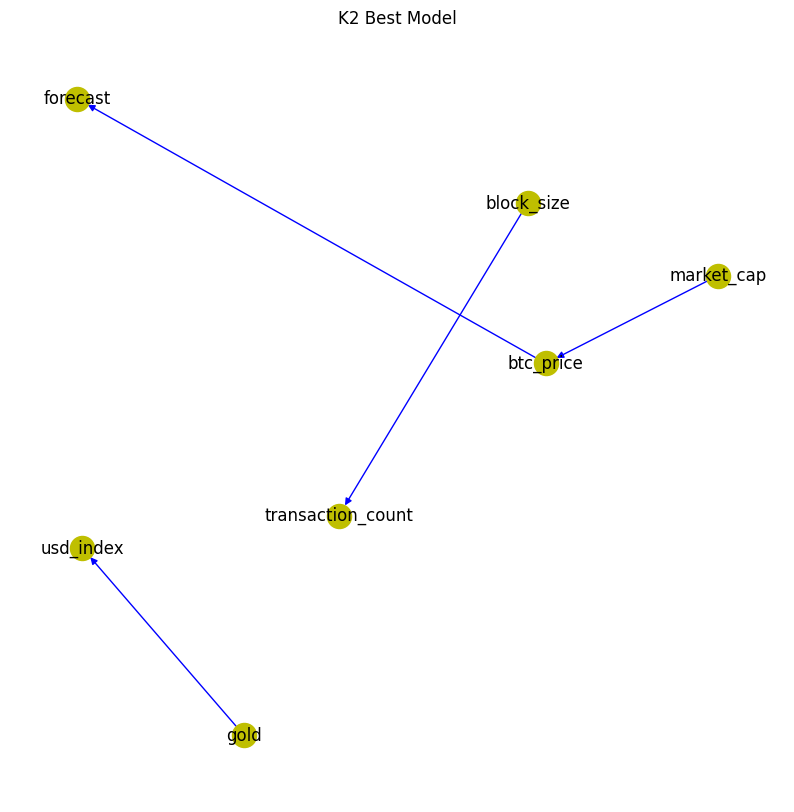

In [12]:
# Create subplots
fig, ax = plt.subplots(figsize=(10, 10))

# Create a directed graph
G1 = nx.DiGraph()

# Assuming K2_best_model is defined and contains the edges
G1.add_edges_from(K2_model.edges())

# Compute position of nodes for a spring layout
pos1 = nx.spring_layout(G1, iterations=10)

# Draw the graph
nx.draw(G1, pos=pos1, node_color='y', with_labels=True, edge_color='b', font_weight=0.5, ax=ax)

# Set title
ax.set_title('K2 Model')

# Show the plot
plt.show()

In [13]:
model_k2 = BayesianNetwork(ebunch=K2_model.edges())
model_k2.fit(train_data)

In [14]:
## Discretise the validation dataset and plot
discretise_data_with_hmm_and_save_csv(vald_data,'validation_data')
states = pd.read_csv("./data/validation_data.csv", index_col=0)
states.index = pd.to_datetime(states.index)
plot_regime_switch(vald_data, states, 'VALIDATION')

In [15]:
def predict_value(model_struct, scoring_method, states):

    column_names_df1 = set(model_struct.nodes())
    column_names_df2 = set(states.columns)
    columns_only_in_df2 = column_names_df2 - column_names_df1

    print(columns_only_in_df2)
    print(column_names_df2)
    print(len(column_names_df1))
    print(len(column_names_df2))
    print(len(columns_only_in_df2))

    data_new = states.drop(columns=list(columns_only_in_df2) + ['forecast'], axis=1)
    print(data_new.shape)
    print(data_new.columns)
    prediction = model_struct.predict(data_new)
    pred_value = prediction['forecast'].to_numpy()
    return pred_value

pred_value_vald_k2 = predict_value(model_k2, 'k2', states)

{'13w_treasury', 'hash_ate', 's&p500', 'block_difficulty'}
{'13w_treasury', 'market_cap', 'hash_ate', 'block_size', 'gold', 'transaction_count', 'block_difficulty', 'usd_index', 'btc_price', 'forecast', 's&p500'}
7
11
4
(49, 6)
Index(['block_size', 'market_cap', 'btc_price', 'transaction_count', 'gold',
       'usd_index'],
      dtype='object')


  0%|          | 0/37 [00:00<?, ?it/s]

In [16]:
# Record real data observation, to be compared with the predicted one
vald_real = states['btc_price'].to_numpy()

print("\nReal Value: ")
print(vald_real);

def calculate_error(pred_value, scoring_method, real):
  print(f'\nPredicted Value {scoring_method}: ')
  print(pred_value)

  error = np.mean(real != np.roll(pred_value, 1))

  print(f'\nError {scoring_method}: ')
  print(error * 100)
  return error

error_vald = calculate_error(pred_value_vald_k2, 'k2',vald_real)


Real Value: 
[1 2 2 1 0 1 0 1 2 2 2 2 1 2 2 1 2 2 1 0 0 0 0 0 0 1 0 1 0 0 1 2 2 2 2 1 2
 2 1 2 2 1 0 1 2 1 2 1 0]

Predicted Value k2: 
[2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 2 0 2 0 0 2 2 2 2 2 2 2
 2 2 2 2 2 0 2 2 2 2 2 0]

Error k2: 
46.93877551020408


After conducting our initial evaluation, we observed a significant error rate of 47% on the validation dataset for our Probabilistic Graphical Model (PGM). Our directed graph plot revealed that only two variables, namely Bitcoin (BTC) price and Market Capitalization, demonstrated the ability to predict the BTC price. On the other hand, other variables did not establish any connection with price prediction, indicating that our PGM's learned structure lacked predictive power beyond the BTC price.

As a result, it is evident that our model requires further refinement to improve its performance. We plan to achieve this by introducing additional variables such as technical indicators, on-chain, financial, and sentimental data, and identifying the most predictive features. Furthermore, we intend to employ other Structure learning approaches such as PC and Exhaustive Search, or a hybrid of constraint and score-based learning. Additionally, we plan to utilize different techniques for parameter learning. 

We expect that these enhancements will optimize both the structure and predictive power of our model, leading to more accurate predictions.